# Library Dependencies

This script only uses `numpy` library for execution of the main code. For plotting graphs we use `matplotlib` and `seaborn`.

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as ss
import numpy.linalg as LA
from scipy.sparse import linalg as SSLA

import seaborn as sns
sns.set()

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Arc
mpl.rcParams['figure.dpi'] = 100

import warnings
warnings.filterwarnings("ignore")

# Helper Functions

Small helper functions for the main program. Computation of distances, angles, normal/tangent vectors is done with these.

In [2]:
def entry_vector(r, entry_theta):
    """
    RETURNS entry vector from initial entry position and angle
    """
    ## Handling of vertical lines
    #if np.abs(entry_theta - np.pi/2) < 1/(10**3):
    #    v_start = np.array([r,1])
    #    v_end = np.array([r, 0.5])
    #    v_delta = v_end - v_start
    #    return v_start, v_end, v_delta
    vec_slope = np.tan(-entry_theta)
    direction = -np.sign(vec_slope)
    ev_f = lambda x: vec_slope*(x-r)+1
    ell = 0.1


    v_start = np.array([r, 1])
    v_end = np.array([v_start[0]+direction*ell, ev_f(v_start[0]+direction*ell)])

    v_delta = v_end - v_start
    return v_start, v_end, v_delta
    
def dist_to_arc(vec, vdelta, arc_center):
    """
    RETURNS shortest distance between a line and a point
    """
    center_x, center_y = arc_center
    m = vdelta[1]/vdelta[0]
    num_ = np.abs(-m*center_x + center_y + (vec[0]-vec[1]))
    denom_ = np.sqrt(1+(m**2))
    return num_/denom_
    
def vector_arc_distances(v_, vdelta_, segment_):
    c_ = segment_["center"]
    radius_ = segment_["radius"]
    
    start_to_center_ = np.dot(c_ - v_, vdelta_)/LA.norm(vdelta_)**2
    v_closest_ = v_ + start_to_center_*vdelta_
    
    #---distance from vector start to center---#
    v_to_center_ = LA.norm(c_ - v_closest_) 
    
    diff_ = radius_**2 - v_to_center_**2
    s_ = np.sign(diff_)
    lenToIntercept_ = np.sqrt(np.abs(diff_))/LA.norm(vdelta_)
    
    #---distance from vector start to collision---#
    v_to_coll_ = start_to_center_ - lenToIntercept_
    
    #---shortest distance line to center---#
    line_to_coll_ = dist_to_arc(v_, vdelta_, c_)
    return np.array([v_to_center_, v_to_coll_, line_to_coll_])

def collision_point(v_start, v, unitD):
    """
    RETURNS collision point with arc
    """
    #---get intercept of line---#
    w_intercept = v_start + unitD*v
    return w_intercept

def tangent_to_circle(w, c, radius_):
    """
    RETURNS tangent vector at arc boundary
    """
    A = np.array([[0, -1], [1,0]])
    return np.matmul(A, w-c)/radius_

def reflected_vec(tangent_w, v_unit, w):
    """
    RETURNS post-collision vector off an arc
    given incoming direction and collision point
    """
    #---distance from the incoming vector end to the tangent line, squared---#
    #---Double it because we want to get the reflection which is on the other side of the tangent line---#
    dot2 = 2*np.dot(tangent_w, v_unit)

    #---lengthen the normalised tangent vector by the dot amount---#
    tangent_v_scaled = tangent_w*dot2
    
    #---reflected vector---#
    z = tangent_v_scaled - v_unit
    z_unit = z/LA.norm(z)
    
    #---end the new reflected line segment---#
    z_reflect = w + z_unit
    return z_reflect

def collision_with_arc(vec_start_, coll_pt_, segment_):
    """
    RETURNS post-collision vector off an arc
    """
    v_delta_  = coll_pt_ - vec_start_
    
    arc_center, radius_ = segment_["center"], segment_["radius"]
    #---tangent vector at collision---#
    tangent_to_coll_pt = tangent_to_circle(coll_pt_, arc_center, radius_)

    #---unit norm incoming vector---#
    v_unit = v_delta_/LA.norm(v_delta_)

    #---post-collision vector---#
    postcoll_pt_ = reflected_vec(
        tangent_to_coll_pt,
        v_unit,
        coll_pt_
    )
    return postcoll_pt_

def collision_with_line(vec_start_, coll_pt_, segment_):
    L_start_, L_end_ = segment_["begin"], segment_["end"]
    
    # case when line is horizontal
    #if L_start_[1] == L_end_[1]:
    #    return collision_with_horz_vert_line(vec_start_, coll_pt_, segment_)
    
    p_, q_ = vec_start_
    # case when line is vertical
    if L_start_[0] == L_end_[0]:
        #return collision_with_horz_vert_line(vec_start_, coll_pt_, segment_)
        a_, b_, c_ = 0, 1, - L_start_[0]

    else:
        slope_ = (L_end_[1] - L_start_[1])/(L_end_[0] - L_start_[0])
        a_, b_, c_ = 1, -slope_, slope_*L_start_[0] - L_start_[1]

    #---calculate reflected coordinates---#
    ref_pt_x_ = (p_*(a_**2 - b_**2) - 2*b_*(a_*q_ + c_))/(a_**2 + b_**2)
    ref_pt_y_ = (q_*(b_**2 - a_**2) - 2*a_*(b_*p_ + c_))/(a_**2 + b_**2)
    ref_ = np.array([ref_pt_x_, ref_pt_y_])
    
    # flip
    ref_dir_ = ref_ - coll_pt_
    ref_ = coll_pt_ - (distance_between(coll_pt_, vec_start_)/LA.norm(ref_dir_))*ref_dir_
    return ref_


def ccw(A,B,C):
    #return (C.y-A.y)*(B.x-A.x) &gt; (B.y-A.y)*(C.x-A.x)
    return (C[1]-A[1])*(B[0]-A[0]) > (B[1]-A[1])*(C[0]-A[0])

def line_intersect_check(A,B,C,D):
    #print(A,B,C,D)
    return ccw(A,C,D) != ccw(B,C,D) and ccw(A,B,C) != ccw(A,B,D)
    
def findIntersection(A, B, C, D):
    x1,y1 = A
    x2,y2 = B
    x3,y3 = C
    x4,y4 = D
    px = ( (x1*y2-y1*x2)*(x3-x4)-(x1-x2)*(x3*y4-y3*x4) ) / ( (x1-x2)*(y3-y4)-(y1-y2)*(x3-x4) ) 
    py = ( (x1*y2-y1*x2)*(y3-y4)-(y1-y2)*(x3*y4-y3*x4) ) / ( (x1-x2)*(y3-y4)-(y1-y2)*(x3-x4) )
    return np.array([px, py])

def distance_between(A_, B_):
    """
    HELPER function
    returns the distance between A and B
    """
    return np.sqrt(((A_[1]-B_[1])**2 ) + ((A_[0]-B_[0])**2 ))

def cosine_sim(v_, w_):
    arg_ = np.dot(v_, w_)/(LA.norm(v_)*LA.norm(w_))
    return np.arccos(arg_)

def chord_len(radius_, angle_):
    return 2*radius_*np.sin(angle_/2)

def invalid_arc_angle(L_, a_):
    if L_[0] < L_[1]:
        if a_ < L_[0]:
            return True
        if a_ > L_[1]:
            return True
    if L_[1] < L_[0]:
        if L_[1] < a_ < L_[0]:
            return True
    return False

# Main billiard cell functions

The three main functions of the program which check all possible collisions with the boundary. The workflow is as follows:
- `check_segment_collisions`: iterates through all the boundary segments and returns a list of possible segments that a given vector can collide with.  
- `next_collision`: identifies (given the output of `check_segment_collisions`) which is the correct boundary segment the particle will collide with. 
- `billiard_cell`: a loop involving the last two functions that ends when the particle exits the cell. Output is the exit vector. 

In [3]:
def check_segment_collisions(segment_list_, v_start_, v_delta_):
    possible_segments_ = []
    #print(f"\t\t all segments {segment_list_}")
    for b_ in segment_list_:
        if b_["type"] == "arc":
            add_first_, add_second_ = True, True
            #---compute distance to collision and shortest line to center---#
            d_center_, dist_to_coll_, vec_to_center_ = vector_arc_distances(v_start_, v_delta_, b_)
            #print(f" center {b_['center']} distances {d_center_, dist_to_coll_, vec_to_center_}")
            
            #---compute shortest distance to line---#
            #m_slope_ = v_delta_[1]/v_delta_[0]
            z1_, z2_ = v_start_
            x0_, y0_ = b_["center"]
            #shortest_distance_ = np.abs(-m_slope_*x0_ + y0_ + (m_slope_*z1_ - z2_))/np.sqrt(1+(m_slope_**2))
            #print(f"alternate shortest distance {shortest_distance_}")
            
            #---if shortest line to center is LARGER than radius -> no intersection---#
            if d_center_ > b_["radius"]:
                continue
                
            #---compute point of collision---#
            arc_pt_ = v_start_ + dist_to_coll_*v_delta_
            
            #print(f"arc collision point {arc_pt_}")
            #print(f"old distance {dist_to_coll_}")
            
            #---compute distane to the point of collision---#
            dist_to_coll_ = distance_between(v_start_, arc_pt_)*np.sign(dist_to_coll_)
            #*np.sign((arc_pt_[1]-v_start_[1])/(arc_pt_[0]-v_start_[0]))
            
            #print(f"new distance {dist_to_coll_}")
                
            #---check if it is in a valid arc---#
            #np.arctan2((np.sqrt((R**2)-1)+(1-R)) - (1-R), 0-1)
            arc_plt_angle_ = np.arctan2(
                arc_pt_[1]-b_["center"][1],
                arc_pt_[0]-b_["center"][0]
            )
            
            arc_plt_angle_ = ((arc_plt_angle_*(180/(2*np.pi))) % 180)*((2*np.pi)/180)
            if invalid_arc_angle(b_['valid_arc'], arc_plt_angle_):
                add_first_ = False #continue
                #pass

            #---ALSO add collison with other side of arc---#
            
            ## SECOND COLLISION POINT ON ARC
            # angle between incoming vector and vector from collision point to center of arc
            phi_ = cosine_sim(
                (arc_pt_ + 5*v_delta_) - arc_pt_,
                b_["center"] - arc_pt_)
            # length of chord between collisions
            chord_btwn_colls_ = chord_len(b_["radius"], np.pi - 2*phi_)
            
            # second point of collision and distance to it
            dist_to_coll_second_ = dist_to_coll_ + chord_btwn_colls_
            #arc_pt_second_ = v_start_ + (dist_to_coll_second_/LA.norm(v_delta_))*v_delta_
            arc_pt_second_ = arc_pt_ + (chord_btwn_colls_/LA.norm(v_delta_))*v_delta_
            
            #---check if it is in a valid arc---#
            arc_plt_angle_second_ = np.arctan2(
                arc_pt_second_[1]-b_["center"][1],
                arc_pt_second_[0]-b_["center"][0]
            )
            arc_plt_angle_second_ = ((arc_plt_angle_second_*(180/(2*np.pi))) % 180)*((2*np.pi)/180)
            if invalid_arc_angle(b_['valid_arc'], arc_plt_angle_second_):
                add_second_ = False
                #continue
                #pass
            
            #---add first to possibilities---#
            if add_first_:
                #---add it to possibilities---#
                possible_segments_.append(
                    np.array([dist_to_coll_, arc_pt_, b_])
                )
            if add_second_:
                possible_segments_.append(
                    np.array([dist_to_coll_second_, arc_pt_second_, b_])
                )
        if (b_["type"] == "line") or (b_["type"] == "pass"):
            v_long_end_ = v_start_ + (10/LA.norm(v_delta_))*v_delta_
            #print(f"\t endpt {v_long_end_}, direction {v_delta_}")
            if line_intersect_check(v_start_, v_long_end_, b_["begin"], b_["end"]):
                #---find intersection point---#
                line_pt_ = findIntersection(v_start_, v_long_end_, b_["begin"], b_["end"])
                
                #print(f"line intersection: point {line_pt_} \n\t segment {b_}")
                
                #---compute distance to vector start---#
                dist_to_coll_ = distance_between(v_start_, line_pt_)#/LA.norm(v_delta_)
                
                #---add it to possibilities---#
                possible_segments_.append(
                    np.array([dist_to_coll_, line_pt_, b_])
                )
        

    if len(possible_segments_) > 0:
        possible_segments_ = np.stack(possible_segments_)
        #print(f" at {v_start_} \n\t possibilities {possible_segments_}")
        return possible_segments_
    else:
        return np.array([])


def next_collision(segment_list_, v_start_, v_delta_, edge_case_ = False, plot_ = False):
    results_ = check_segment_collisions(segment_list_, v_start_, v_delta_)
    
    #---CASE WHEN NO COLLISIONS---#
    if len(results_) == 0:
        #print("NONE")
        return None, None
    #    return exit_collision(v_start_, v_delta_, current_segment_)
    
    sort_by_distance_ = results_[results_[:,0].argsort()]
    #sort_by_distance_valid_ = sort_by_distance_[(sort_by_distance_[:,0] > 1/(10**5))]
    if edge_case_:
        sort_by_distance_valid_ = sort_by_distance_[(sort_by_distance_[:,0] > 0 )]
    else:
        sort_by_distance_valid_ = sort_by_distance_[(sort_by_distance_[:,0] > 1/(10**5))]
    
    #if sort_by_distance_[0][0] < 1/(10**5):
    if len(sort_by_distance_valid_) == 0:
        return None, None
    
    #print(f"Done filtering \n {sort_by_distance_valid_}")
    
    collision_point_, next_segment_ = sort_by_distance_valid_[0][1:]
    # get post-collision
    if next_segment_["type"] == "arc":
        post_collision_point_ = collision_with_arc(
            vec_start_=v_start_,
            coll_pt_=collision_point_,
            segment_=next_segment_)
        
        # case when collision is bump knot
        #if np.abs(collision_point_[0] - 1/2) < 10e-4:
        #    post_collision_point_ = np.array([1/2, 1])
        return collision_point_, post_collision_point_ 
    if next_segment_["type"] == "line":
        post_collision_point_ = collision_with_line(
            vec_start_=v_start_,
            coll_pt_=collision_point_,
            segment_=next_segment_)
        return collision_point_, post_collision_point_ 
    if next_segment_["type"] == "pass":
        if plot_:
            ax_plot_vec(v_start_, collision_point_, color="pink")

            
        coll_x_, coll_y_ = collision_point_
        coll_delta_ = collision_point_ - v_start_
        
        new_vstart_ = np.array([next_segment_["xpt"], coll_y_])
        new_collpt_ = new_vstart_ + (0.1/LA.norm(coll_delta_))*coll_delta_
        return new_vstart_, new_collpt_

In [4]:
def get_exit_vector(v_start_, v_end_, segment_list_, angle_only_=False):
    for b_ in segment_list_:
        if b_["type"] == "exit":
            v_delta_ = v_end_ - v_start_
            v_long_end_ = v_start_ + (10/LA.norm(v_delta_))*v_delta_
            #print(f"\t endpt {v_long_end_}, direction {v_delta_}")
            
            if line_intersect_check(v_start_, v_long_end_, b_["begin"], b_["end"]):
                #---find intersection point---#
                line_pt_ = findIntersection(v_start_, v_long_end_, b_["begin"], b_["end"])
                                
                #---compute distance to vector start---#
                dist_to_coll_ = distance_between(v_start_, line_pt_)/LA.norm(v_delta_)
                
                #---get vector outside of the cell---#
                exit_a_ = line_pt_
                exit_b_ = line_pt_ + (0.2/LA.norm(v_delta_))*v_delta_
                
                #---angle---#
                exit_angle_ = cosine_sim(
                    v_ = exit_b_ - exit_a_,
                    w_ = b_["end"] - b_["begin"]
                )
                if angle_only_:
                    return exit_angle_
                else:
                    return exit_a_, exit_b_, exit_angle_
    #print("NO VALID EXIT")

def billiard_cell(position_, init_angle_, boundary_, plot=False, angle_only_=False, entry_pos_dist_=None):
    if entry_pos_dist_ is not None:
        position_ = entry_pos_dist_.rvs()
        
    # initiate the entry vector
    v_start_, v_end_, v_delta_ = entry_vector(r=position_, entry_theta=init_angle_)
    
    # compute collisions until we get an exit vector
    if (np.abs(position_) < 10e-2) or (np.abs(1-position_) < 10e-2):
        #print("edge")
        init_coll_v_start_, init_coll_v_end_ = next_collision(
            v_start_ = v_start_,
            v_delta_ = v_delta_,
            segment_list_ = boundary_, 
            edge_case_ = True,
            plot_ = plot
        )
    else:
        init_coll_v_start_, init_coll_v_end_ = next_collision(
            v_start_ = v_start_,
            v_delta_ = v_delta_,
            segment_list_ = boundary_, 
            plot_ = plot
        )

    # plot vectors if necessary
    if plot:
        ax_plot_vec(v_start_, init_coll_v_start_, color="blue", label="Entry Vector")
    while True:
        # otherwise compute next collison
        next_coll_v_start_, next_coll_v_end_ = next_collision(
            v_start_ = init_coll_v_start_,
            v_delta_ =  init_coll_v_end_ - init_coll_v_start_,
            segment_list_ = boundary_,
            plot_ = plot
        )

        # if no more collisions we exit
        if (next_coll_v_start_ is None) & (next_coll_v_end_ is None):
            break
        
        #print(f"iter {i} init vecs {init_coll_v_start_, init_coll_v_end_} \n next vecs {next_coll_v_start_, next_coll_v_end_}")
        
        # plot vectors if necessary
        if plot:
            ax_plot_vec(init_coll_v_start_, next_coll_v_start_, color="violet")
        
        # reset initial vectors for next loop
        init_coll_v_start_, init_coll_v_end_ = next_coll_v_start_, next_coll_v_end_
    
    #return init_coll_v_start_, init_coll_v_end_
    exit_a_, exit_b_, exit_angle_ = get_exit_vector(init_coll_v_start_, init_coll_v_end_, boundary_)
    if plot:
        # plot last collision in cell
        ax_plot_vec(init_coll_v_start_, exit_a_, color="violet")   
        # plot exit vector
        ax_plot_vec(exit_a_, exit_b_, color="green", label="Exit Vector")  
    if angle_only_:
        return exit_angle_
    else:
        return exit_a_, exit_b_, exit_angle_

# Parameter Families

In [5]:
def make_arc(radius_, center_, valid_arc_):
    """
    RETURNS a dictionary speciying an arc boundary segment
    """
    keys_ = ["radius", "center", "valid_arc"]
    d_ = dict(zip(keys_, [radius_, np.array(center_), np.array(valid_arc_)]))
    return {**d_, **{"type":"arc"}}

def make_line(begin_, end_):
    """
    RETURNS a dictionary specifying a line boundary segment
    """
    keys_ = ["begin", "end"]
    d_ = dict(zip(keys_, [np.array(begin_), np.array(end_)]))
    return {**d_, **{"type":"line"}}

def make_pass_line(begin_, end_, xpt_):
    keys_ = ["begin", "end", "xpt"]
    d_ = dict(zip(keys_, [np.array(begin_), np.array(end_), xpt_]))
    return {**d_, **{"type":"pass"}}

def make_exit_line(begin_, end_):
    keys_ = ["begin", "end"]
    d_ = dict(zip(keys_, [np.array(begin_), np.array(end_)]))
    return {**d_, **{"type":"exit"}}

def bumps_with_hole(radius_, wall_height_, wall_width_=0):
    # y value of point where the two arcs meet the wall
    merge_y_ = np.sqrt((radius_**2)-((1/2) - (wall_width_/2))**2)+(1-radius_)
    
    # angle w.r.t. center of the point where the two arcs meet
    merge_angle_ = np.arctan2(merge_y_ - (1-radius_), (1/2) - (wall_width_/2))
    
    # make sure wall doesn't extend exit segment
    y_height_ = merge_y_ + wall_height_
    
    #print(f"Y height: {y_height_}")
    
    if y_height_ < 0.975:
        boundary_ = [
            make_arc(radius_, [0, 1-radius_], [merge_angle_, np.pi/2]),
            make_arc(radius_, [1, 1-radius_], [np.pi/2, np.pi - merge_angle_]),
            make_exit_line([0, 1], [1,1])
        ]

        # if width is zero we only add one line
        if wall_width_ == 0:
            boundary_.append(make_line([1/2, merge_y_], [1/2, y_height_]))
        # otherwise we make a rectangle
        else:
            base_x1, base_x2 = (1/2) - (wall_width_/2), (1/2) + (wall_width_/2)
            boundary_ = boundary_ + [
                make_line([base_x1, merge_y_], [base_x1, y_height_]), 
                make_line([base_x2, merge_y_], [base_x2, y_height_]),
                make_line([base_x1, y_height_], [base_x2, y_height_])
            ]
        return boundary_
    
    if y_height_ >= 0.975:
        diff_ = np.abs(0.95 - y_height_)
        #print(f"Diff {diff_}")
        
        # update meger point
        merge_y_ = merge_y_ - diff_
        
        # angle w.r.t. center of the point where the two arcs meet
        #merge_angle_ = np.arctan2(merge_y_ - (1-radius_), (1/2) - (wall_width_/2))

        # make sure wall doesn't extend exit segment
        y_height_ = merge_y_ + wall_height_
        
        boundary_ = [
            make_arc(radius_, [0, 1-radius_-diff_], [merge_angle_, np.pi/2]),
            make_arc(radius_, [1, 1-radius_-diff_], [np.pi/2, np.pi - merge_angle_]),
            make_exit_line([0, 1], [1,1]),
            make_pass_line([0, 1-diff_], [0, 1], xpt_=1),
            make_pass_line([1, 1-diff_], [1, 1], xpt_= 0)
        ]

        # if width is zero we only add one line
        if wall_width_ == 0:
            boundary_.append(make_line([1/2, merge_y_], [1/2, y_height_]))
        # otherwise we make a rectangle
        else:
            base_x1, base_x2 = (1/2) - (wall_width_/2), (1/2) + (wall_width_/2)
            boundary_ = boundary_ + [
                make_line([base_x1, merge_y_], [base_x1, y_height_]), 
                make_line([base_x2, merge_y_], [base_x2, y_height_]),
                make_line([base_x1, y_height_], [base_x2, y_height_])
            ]
        return boundary_

# Plotting Functions

For visualization of the results. 

In [6]:
def ax_plot_vec(v1, v2, color="red", label=None, ls="-"):
    """
    PLOTS the line segment from v1 to v2
    """
    ax.plot([v1[0], v2[0]], [v1[1], v2[1]], c=color, label=label, ls=ls)
    
    
def plot_arc(D_, **kwargs):
    ax.add_patch(Arc(
        xy=D_["center"],
        height=2*D_["radius"],
        width=2*D_["radius"], 
        theta1=(D_["valid_arc"][0])*(180/np.pi),
        theta2=(D_["valid_arc"][1])*(180/np.pi),
        **kwargs))
    
def plot_line(D_, **kwargs):
    x1, y1 = np.vstack((D_["begin"], D_["end"])).T
    plt.plot(x1, y1, lw=1, **kwargs)
    
    
def plot_segments(boundary_, show_=True):
    # Figure setup
    fig_width, fig_height = 10, 10
    fig = plt.figure(figsize=(fig_width, fig_height), frameon=False)

    global ax
    ax = fig.add_axes([0.0, 0.0, 1.0, 1.0], aspect='equal')

    # Arcs
    my_label = "Boundary Segment"
    exit_label = "Exit Segment"
    pass_label = "Pass Segment"
    for C in boundary_:
        if C["type"] == "arc":
            plot_arc(C, label=my_label, edgecolor='red')
            my_label = "_nolegend_"
        if C["type"] == "line":
            plot_line(C, label=my_label, c="red")
            my_label = "_nolegend_"
        if C["type"] == "pass":
            plot_line(
                C,
                label=pass_label,
                ls="-.",
                c="blue")
            pass_label = "_nolegend_"
        if C["type"] == "exit":
            plot_line(
                C,
                label=exit_label,
                ls="-.",
                c="green")
            exit_label = "_nolegend_"        
    if show_:
        plt.legend()
        plt.show()
    else:
        return ax

def plot_billiard_cell(position_, init_angle_, boundary_, entry_pos_dist_=None):
    # Figure setup
    #fig_width, fig_height = 10, 10
    #fig = plt.figure(figsize=(fig_width, fig_height), frameon=False)

    #global ax
    #ax = fig.add_axes([0.0, 0.0, 1.0, 1.0], aspect='equal')
    global ax
    ax = plot_segments(boundary_=boundary_, show_=False)
            
    # exit vector
    fcoll_, v_exit_, fangle_ = billiard_cell(
        position_,
        init_angle_,
        boundary_,
        plot=True,
        entry_pos_dist_=entry_pos_dist_)
    
    #ax_plot_vec(fcoll, v_exit)
    #ax.plot([fcoll_[0], v_exit_[0]], [fcoll_[1], v_exit_[1]], c="green", label="Exit Vector")
    
    #plt.title(r"Initial angle $\theta = {}$,  Entry Position $r = {}$, Exit Angle {}"\
    #          .format(*np.round([init_angle_, , fangle_], 3)))
    plt.legend()
    plt.show()
    
    #plt.legend()
    plt.show()
    
from mpl_toolkits.mplot3d import Axes3D

def surface_plot(matrix, **kwargs):
    # acquire the cartesian coordinate matrices from the matrix
    # x is cols, y is rows
    (x, y) = np.meshgrid(np.arange(matrix.shape[0]), np.arange(matrix.shape[1]))
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    surf = ax.plot_surface(x, y, matrix, **kwargs)
    return (fig, ax, surf)

# Proof of concept

This script creates general billiard cells using arcs (segments of circles) and lines. Two things have to be specified by the user for it to operate:
1. A list of the boundary segments
2. Initial entry coordinates and initial angle at which the particle enters the cell. 

The boundary segments are specified in the following way.


## Arcs

A dictionary with the keys and values as below
- `type`: set to'arc',
- `radius`: the radius of the circle as a float,
- `center`: the center of the circle as a `numpy.array`, i.e. `np.array([c1, c2])`,
- `valid_arc`: the portion (in radians) of the circle to use as a `numpy.array`, i.e. `np.array([0, 2*np.pi])`.

## Lines
A dictionary with the keys and values as below
- `type`: set to 'line',
- `begin`: the starting point of the line as a `numpy.array`,
- `end`: the ending point of the line as a `numpy.array`. 
Ordering of the begining/endpoints of a line segment does not matter. 

## Exits
A line segment but type is set to `exit` instead of line. Note that ordering of `begin` and `end` points matters when computing the exit angle as this is done via the cosine similarity. 

- `type`: set to 'exit',
- `begin`: the starting point of the line as a `numpy.array`,
- `end`: the ending point of the line as a `numpy.array`. 

## An example

The following helper functions allow for a quick way to specify a boundary segment using lists. We end this script with an example. 

In [7]:
example = [
    make_line([-0.75, 1], [-1, 1]),
    make_line([-1,1], [-1,0.2]),
    make_line([-0.8,0], [1,0]),
    make_arc(0.2, [-1,0], [0, np.pi/2]),
    make_line([1,0], [1,1]),
    make_arc(0.1, [-0.5, 0.8], [np.pi/2, 3*np.pi/2]), 
    make_arc(0.1, [-0.5, 0.6], [3*np.pi/2, np.pi/2]), 
    make_arc(0.1, [-0.5, 0.4], [np.pi/2, 3*np.pi/2]),
    make_arc(0.1, [-0.5, 0.2], [3*np.pi/2, np.pi/2]),
    make_arc(0.25, [0, 0.5], [0, 2*np.pi]),
    make_line([0.5, 0.1], [0.75, 0.1]), 
    make_line([0.5, 0.1], [0.625, 0.35]),
    make_line([0.75, 0.1], [0.625, 0.35]),
    make_line([0.625, 0.35], [0.625, 0.8]),
    make_arc(0.125, [0.5, 0.8], [0, np.pi]),
    make_arc(0.1, [0.375, 0.7], [0, 2*np.pi]),
    make_exit_line([-0.75, 1], [1,1])
]

## The boundary in our example

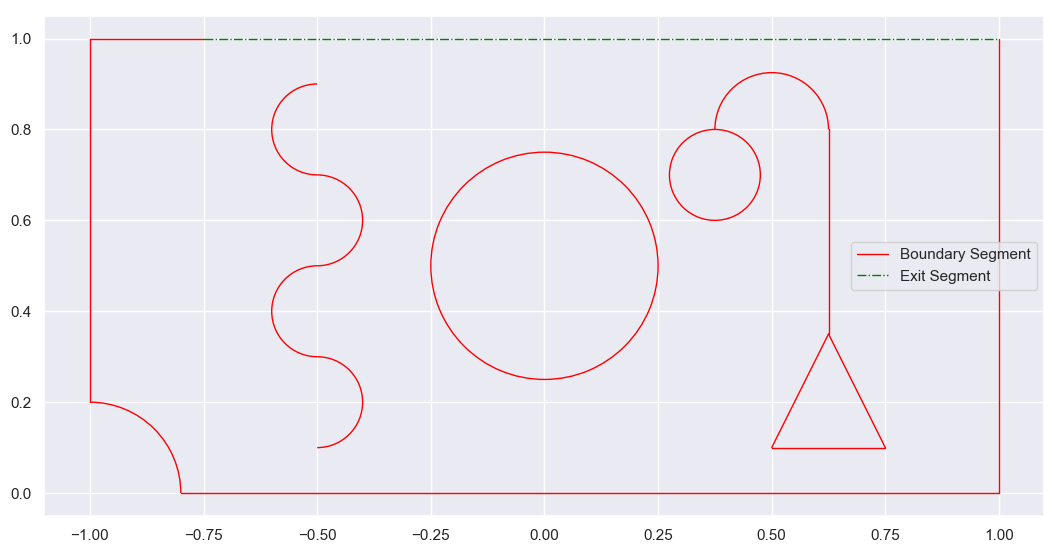

In [8]:
plot_segments(example)

## Visualizing the collisions

We plot serval collisions to inspect the program is working as expected. The entry vector is displayed in green and the exit vector in blue. 

In [9]:
position_partition = np.round(np.linspace(start=-0.75, stop=1, num=2, endpoint=False)[1:], 2)
angle_partition = np.round(np.linspace(start=0, stop=np.pi, num=3
                              , endpoint=False)[1:], 2)
#len(position_partition)*len(angle_partition)

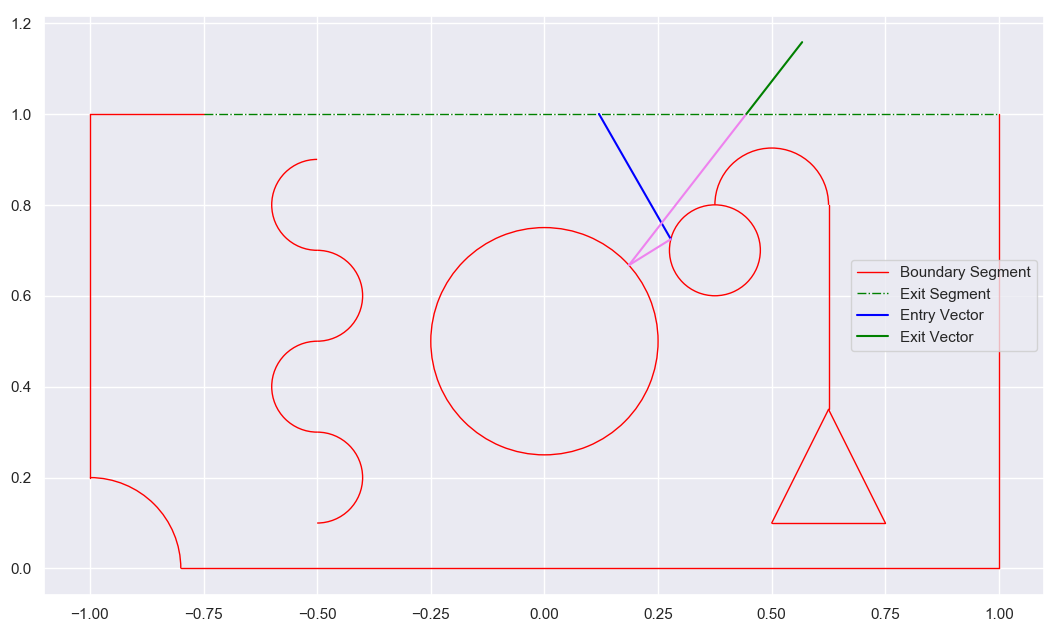

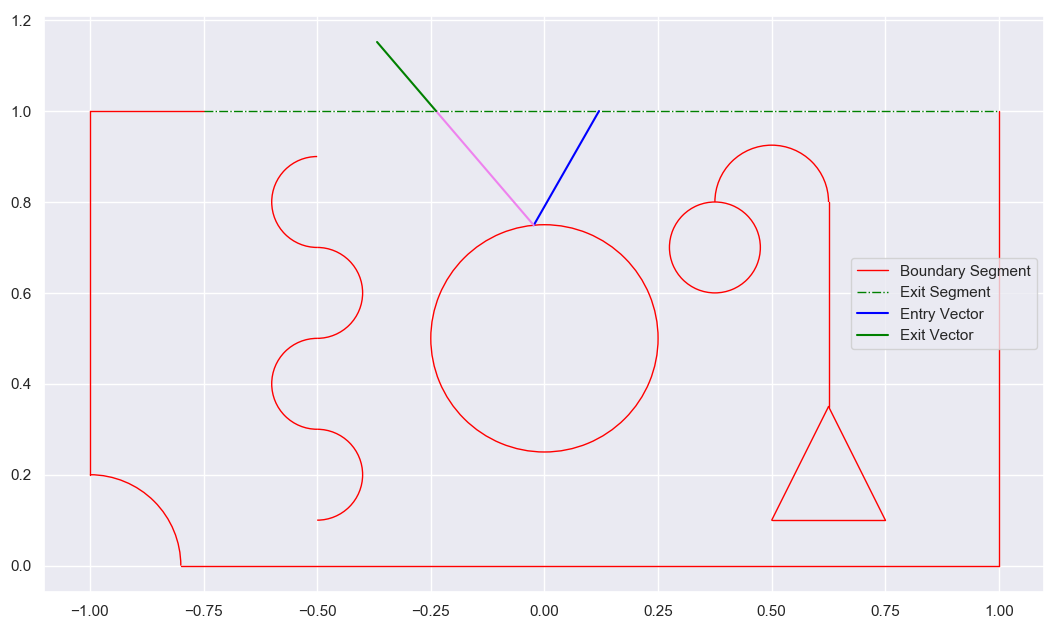

In [10]:
for r_ in position_partition:
    for a_ in angle_partition:
        plot_billiard_cell(
            position_ = r_,
            init_angle_= a_,
            boundary_ = example)

# Parameter Families

## Bumps

In [11]:
def bumps_family(radius_):
    # y value of point where the two arcs meet (x value is 1/2)
    merge_y_ = np.sqrt((radius_**2)-(1/4))+(1-radius_)
    
    # angle w.r.t. center of the point where the two arcs meet
    merge_angle_ = np.arctan2(merge_y_ - (1-radius_), 1/2)
    
    bumps_boundary_ = [
    make_arc(radius_, [0, 1-radius_], [merge_angle_, np.pi/2]),
    make_arc(radius_, [1, 1-radius_], [np.pi/2, np.pi - merge_angle_]),
    make_exit_line([0, 1], [1,1])
    ]
    
    return bumps_boundary_

In [12]:
def plot_segment_list(boundary_list_, show_=True):
    # Figure setup
    fig_width, fig_height = 10, 10
    fig = plt.figure(figsize=(fig_width, fig_height), frameon=False)

    global ax
    ax = fig.add_axes([0.0, 0.0, 1.0, 1.0], aspect='equal')

    # Arcs
    my_label = "Boundary Segment"
    exit_label = "Exit Segment"
    pass_label = "Pass Segment"
    
    trans_ = np.linspace(start=1, stop=0.5, num=len(boundary_list_))
    for i_, boundary_ in enumerate(boundary_list_):
        for C in boundary_:
            if C["type"] == "arc":
                plot_arc(C, edgecolor='black', alpha=trans_[i_])
                my_label = "_nolegend_"
            if C["type"] == "line":
                plot_line(C, c="black", alpha=trans_[i_])
                my_label = "_nolegend_"
#         if C["type"] == "pass":
#             plot_line(
#                 C,
#                 label=pass_label,
#                 ls="-.",
#                 c="blue")
#             pass_label = "_nolegend_"
#         if C["type"] == "exit":
#             plot_line(
#                 C,
#                 label=exit_label,
#                 ls="-.",
#                 c="green")
#             exit_label = "_nolegend_"        
    if show_:
        plt.legend()
        plt.show()
    else:
        return ax

In [13]:
#plot_segment_list([bumps_family(3/4), bumps_family(1/2)])

In [14]:
def three_bumps_family(radius_, small_radius_):
    # y value of point where the two arcs meet (x value is 1/2)
    merge_y_ = np.sqrt((radius_**2)-(1/4))+(1-radius_)
    
    # angle w.r.t. center of the point where the two arcs meet
    merge_angle_ = np.arctan2(merge_y_ - (1-radius_), 1/2)
    
    
    m_height = merge_y_ + small_radius_
    if m_height > 0.95:
        diff_ = m_height - 0.95
        #wall_height_ = wall_height_ - diff_
        #print(f"diff {diff_}, adj {0.95+diff_}")
    else:
        diff_ = 0
        
        
    bumps_boundary_ = [
        make_arc(radius_, [0, 1-radius_-diff_], [merge_angle_, np.pi/2]),
        make_arc(radius_, [1, 1-radius_-diff_], [np.pi/2, np.pi - merge_angle_]),
        make_arc(small_radius_, [0.5, merge_y_-diff_], [0, np.pi]),
        make_exit_line([0, 1], [1,1]),
        make_pass_line([0, 1-radius_-diff_], [0, 1], xpt_=1),
        make_pass_line([1, 1-radius_-diff_], [1, 1], xpt_= 0)
    ]
    
    return bumps_boundary_

In [15]:
#plot_segments(three_bumps_family(0.75, 0.2))

## Bumps with wall

In [16]:
def bumps_with_wall(radius_, wall_height_, wall_width_=0):
    base_len = 2*radius_ + wall_width_
    nradius = radius_
    nwall_width_ = wall_width_
    
    
    merge_y_ = np.sqrt((radius_**2)-(1/4))
    
    # angle w.r.t. center of the point where the two arcs meet
    merge_y_angle = np.sqrt((radius_**2)-(1/4))+(1-radius_)
    merge_angle_ = np.arctan2(merge_y_angle - (1-radius_), 1/2)
    
    #---Adjust for height---#
    if wall_height_+merge_y_ > 0.95:
        diff_ = wall_height_ + merge_y_- 0.95
        
        #wall_height_ = wall_height_ - diff_
        #print(f"diff {diff_}, adj {0.95+diff_}")
    else:
        diff_ = 0        
    #---Y pt where bummps meet---#
    #merge_y_ = np.sqrt((nradius**2)-(1/4))+(1-nradius)
    
    # Angle w.r.t. center of the point where the two arcs meet
    #merge_angle_ = np.arctan2(merge_y_ - (1-nradius), 1/2)
    boundary_ = [
        make_arc(nradius, [0, 0-diff_], [merge_angle_, np.pi/2]),
        make_arc(nradius, [wall_width_+1, 0-diff_], [np.pi/2, np.pi-merge_angle_])
    ]
    #print(f"circle center {[0, 0-diff_-merge_y_]}")
    
    if nwall_width_ == 0:
        boundary_ += [
            make_line([1/2, 0-diff_+merge_y_], [1/2, wall_height_-diff_+merge_y_])
        ]

    # otherwise we make a rectangle
    else:
        base_x1, base_x2 = (1/2) , (1/2) + nwall_width_ 
        boundary_ += [
            make_line([base_x1, 0-diff_+merge_y_], [base_x1, wall_height_-diff_+merge_y_]), 
            make_line([base_x2, 0-diff_+merge_y_], [base_x2, wall_height_-diff_+merge_y_]),
            make_line([base_x1, wall_height_-diff_+merge_y_], [base_x2, wall_height_-diff_+merge_y_])
        ]
        #print(f"base start {[base_x1, 0-diff_-merge_y_]}")
        
    #---add pass lines and entry segment---#
    boundary_ += [
        make_exit_line([0, 1], [wall_width_+1,1]),
        make_pass_line([0, 1-nradius-diff_-merge_y_], [0, 1], xpt_=wall_width_+1),
        make_pass_line([wall_width_+1, 1-nradius-diff_-merge_y_], [wall_width_+1, 1], xpt_= 0)
        ]
    return boundary_

r_ = 1.2
for a_ in [-np.pi/4]:
    plot_billiard_cell(
        position_ = r_,
        init_angle_= a_,
        boundary_ = bumps_with_wall(radius_=0.75, wall_width_=0.3, wall_height_=0.2)
    )

# constant height, vary width

for w_ in [0, 0.1, 0.2, 0.3, 0.5, 0.75, 1]:
    print(w_)
    print(f"height {1.3}")
    plot_segments(bumps_with_wall(radius_=1/2, wall_width_=w_, wall_height_=1.3))

# Small Curvature

In [17]:
def bumps_with_flat(alpha):
    rad_ = (1-alpha)/2
    # angle w.r.t. center of the point where the two arcs meet
    
    boundary_ = [
        make_arc(rad_, [rad_,0], [np.pi/2, np.pi]),
        make_arc(rad_, [1-rad_,0], [0, np.pi/2]),
        make_line([rad_, rad_], [1-rad_, rad_]),
        make_exit_line([0, 1], [1,1]),
        make_pass_line([1, 0], [1,1], xpt_=0),
        make_pass_line([0, 0], [0,1], xpt_=1)
    ]
    
    return boundary_

In [18]:
#plot_segments(bumps_with_flat(alpha=0.6))

In [19]:
def semicircle_family(gap_):
    rad_ = (1-gap_)/2
    print(f"gap: {gap_}, radius: {rad_}, sum: {gap_+2*rad_}")
    #print(f"radius {rad_}")
    mline_begin_, mline_end_ = 0.50-(gap_/2), 0.50+(gap_/2)
    left_center_x_, right_center_x_ = mline_begin_-rad_, mline_end_+rad_
    
    # angle w.r.t. center of the point where the two arcs meet
    
    boundary_ = [
        make_arc(rad_, [0,0], [0, np.pi/2]),
        make_arc(rad_, [1,0], [np.pi/2, np.pi]),
        make_line([mline_begin_, 0], [mline_end_, 0]),
        make_exit_line([0, 1], [1,1]),
        make_pass_line([1, 0], [1,1], xpt_=0),
        make_pass_line([0, 0], [0,1], xpt_=1)
    ]
    
    return boundary_

plot_segment_list([
    semicircle_family(gap_) for gap_ in [0.05, 0.1, 0.15, 0.2]
]
)

plot_segment_list([
    semicircle_family(gap_) for gap_ in [0.6, 0.7, 0.8, 0.9, 1]
]
)

for g in [0, 0.5, 0.75, 0.8, 1]:
    plot_segments(semicircle_family(g))

for r_ in [0.53, 0.43]:
    for a_ in [np.pi/4, np.pi/3]:
        plot_billiard_cell(
            position_ = r_,
            init_angle_= a_,
            boundary_ = semicircle_family(0.80))

In [20]:
def semicircle_focus_family(gap_):
    rad_ = (1-gap_)/2
    #print(f"radius {rad_}")
    mline_begin_, mline_end_ = 0.50-(gap_/2), 0.50+(gap_/2)
    left_center_x_, right_center_x_ = mline_begin_-rad_, mline_end_+rad_
    
    # angle w.r.t. center of the point where the two arcs meet
    
    boundary_ = [
        make_arc(rad_, [0,0], [3*np.pi/2, 2*np.pi]),
        make_arc(rad_, [1,0], [np.pi, 3*np.pi/2]),
        make_line([mline_begin_, 0], [mline_end_, 0]),
        make_exit_line([0, 1], [1,1]),
        make_pass_line([1, 0-rad_], [1,1], 0),
        make_pass_line([0, 0-rad_], [0,1], 1)
    ]
    
    return boundary_

plot_segment_list([
    semicircle_focus_family(gap_) for gap_ in [0.05, 0.1, 0.15, 0.2]
]
)

plot_segment_list([
    semicircle_focus_family(gap_) for gap_ in [0.6, 0.7, 0.8, 0.9, 1]
])

for g in [0, 0.5, 0.75, 0.8, 1]:
    plot_segments(semicircle_focus_family(g))

## Walls from Paper 

From page 11 of https://www.math.wustl.edu/~feres/spectralgapnew.pdf

Radius > 1/2

In [21]:
def arc_with_arc_walls(radius_, width_, height_):
    center_y = 0.9-radius_
    
    # point where arc meets wall
    line_meet_arc_ = np.sqrt(radius_**2 - (width_ - (1/2))**2) + 0.9 - radius_
    
    # angles between walls
    langle_ = np.arctan2(line_meet_arc_ - center_y, width_ - 1/2)
    rangle_ = np.arctan2(line_meet_arc_ - center_y, (1-width_) - 1/2)
    
    # wall height
    wall_y = line_meet_arc_ + height_
    #print(f"wally {wall_y}")
    if wall_y < 0.9:
        boundary_ = [
            #make_line([0, wall_y+width_], [0, line_meet_arc_]), # left wall
            make_line([width_, wall_y], [width_, line_meet_arc_]),
            make_arc(center_=[0, wall_y], radius_=width_, valid_arc_=[0, np.pi/2]), # left bump
            #make_line([1, wall_y+width_], [1, line_meet_arc_]), # right wall
            make_line([1-width_, wall_y], [1-width_, line_meet_arc_]),
            make_arc(center_=[1, wall_y], radius_=width_, valid_arc_=[np.pi/2, np.pi]), # right bump
            make_arc(center_=[1/2, center_y], radius_=radius_, valid_arc_=np.sort([rangle_, langle_])), # center arc
            make_exit_line([0, 1], [1,1]) # exit line
        ]
        
        boundary_.append(
            make_pass_line([0, wall_y+width_], [0,1], 1))
        boundary_.append(
            make_pass_line([1, wall_y+width_], [1,1], 0))
        return boundary_
    else:
        diff_ = np.abs(0.9 - wall_y)
        
        center_y = center_y - diff_

        # point where arc meets wall
        line_meet_arc_ = line_meet_arc_ - diff_

        # angles between walls
        langle_ = np.arctan2(line_meet_arc_ - center_y, width_ - 1/2)
        rangle_ = np.arctan2(line_meet_arc_ - center_y, (1-width_) - 1/2)

        # wall height
        wall_y = wall_y - diff_
        
        boundary_ = [
            make_line([0, wall_y+width_], [0, line_meet_arc_]), # left wall
            make_line([width_, wall_y], [width_, line_meet_arc_]),
            make_arc(center_=[0, wall_y], radius_=width_, valid_arc_=[0, np.pi/2]), # left bump
            make_line([1, wall_y+width_], [1, line_meet_arc_]), # right wall
            make_line([1-width_, wall_y], [1-width_, line_meet_arc_]),
            make_arc(center_=[1, wall_y], radius_=width_, valid_arc_=[np.pi/2, np.pi]), # right bump
            make_arc(center_=[1/2, center_y], radius_=radius_, valid_arc_=np.sort([rangle_, langle_])), # center arc
            make_exit_line([0, 1], [1,1]) # exit line
        ]
        
        boundary_.append(
            make_pass_line([0, wall_y+width_], [0,1], 1))
        boundary_.append(
            make_pass_line([1, wall_y+width_], [1,1], 0))
        return boundary_

# plot segments
plot_segment_list([
    arc_with_arc_walls(height_=0.2, radius_=0.5, width_=0.1),
    arc_with_arc_walls(height_=0, radius_=0.5, width_=0.1),
    arc_with_arc_walls(height_=-0.2, radius_=0.5, width_=0.1)
])

# plot segments
plot_segment_list([
    arc_with_arc_walls(height_=0.2, radius_=0.5, width_=0.1),
    arc_with_arc_walls(height_=0.2, radius_=0.75, width_=0.1),
    arc_with_arc_walls(height_=0.2, radius_=1, width_=0.1)
])

## Triangles

In [22]:
def triangle_family(y_):
    # y value of point where the two lines meet
    
    boundary_ = [
        make_line([0, 1], [1/2, y_]),
        make_line([1, 1], [1/2, y_]),
        make_exit_line([0, 1], [1,1])
    ]
    
    return boundary_

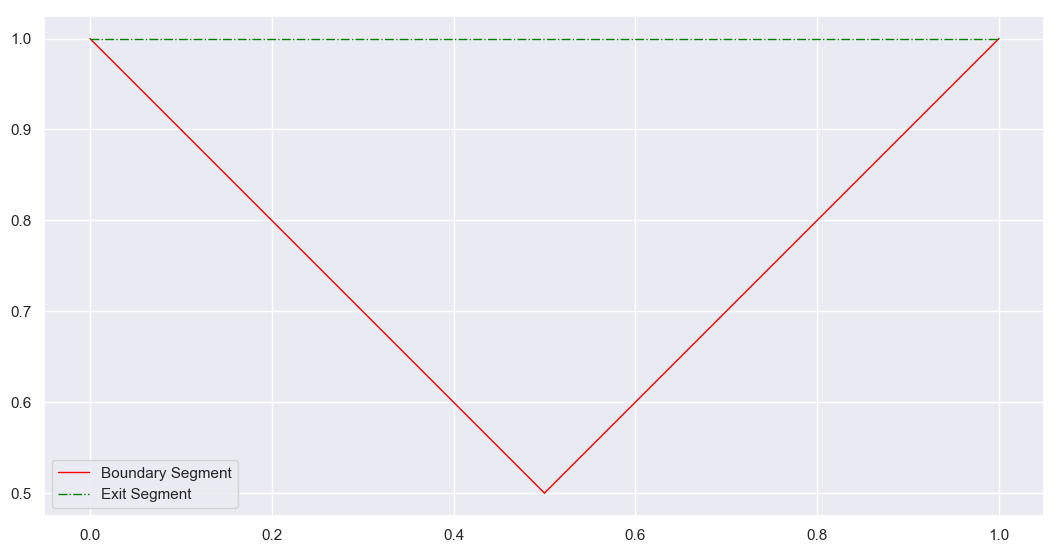

In [23]:
plot_segments(triangle_family(1/2))

# DISPLAY

Collision paths are broken with the addition of passing walls. 

The light pink trajectories are the correct ones when the particle exits through the side. 

In the example below the blue-purple trajectory is incorrect; the correct one is given by the pink-purple trajectory so that the particle re-enters the opposite wall. From here, its purple-pink-green and the particle exits the cell.

All of the other purple trajectories, e.g. the one that passes though the wall, are incorrectly displayed. 

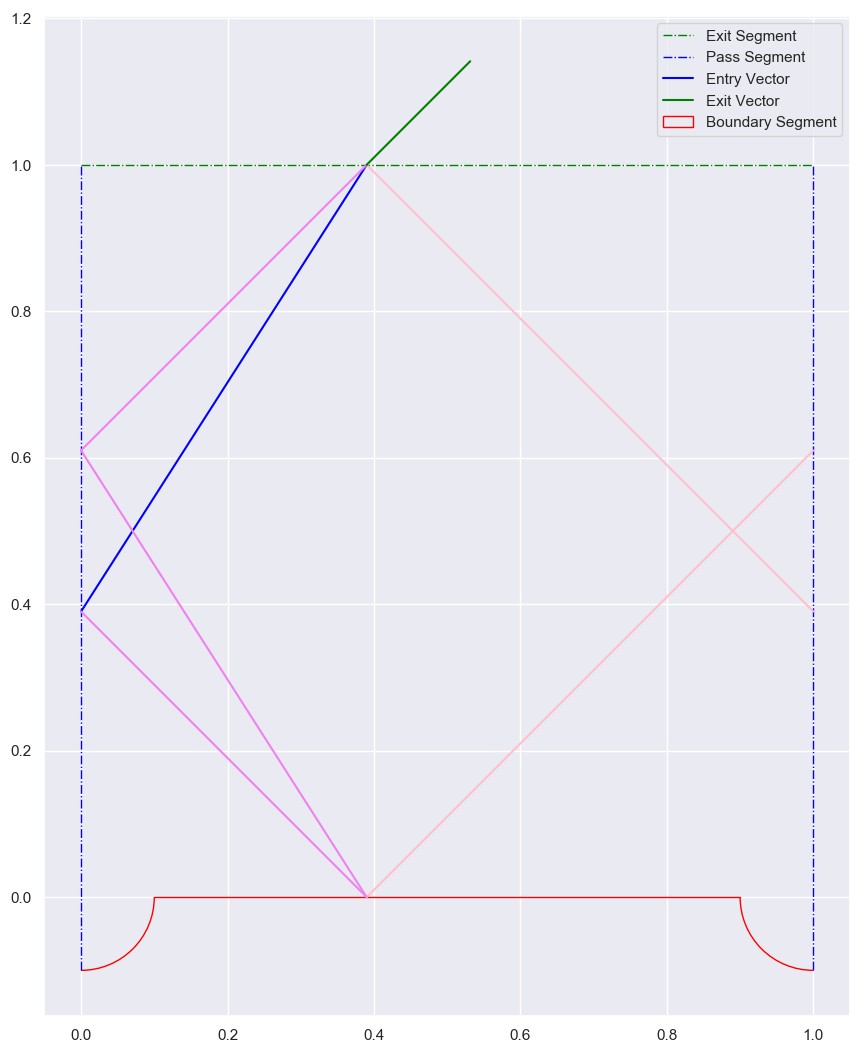

In [24]:
for r_ in [0.39]:
    for a_ in [np.pi/4]:
        plot_billiard_cell(
            position_ = r_,
            init_angle_= a_,
            boundary_ = semicircle_focus_family(0.80))

In [25]:
position_partition = np.round(np.linspace(start=0, stop=1, num=3, endpoint=False)[1:], 2)
angle_partition = np.round(np.linspace(start=0, stop=np.pi, num=4
                              , endpoint=False)[1:], 2)
len(position_partition)*len(angle_partition)

6

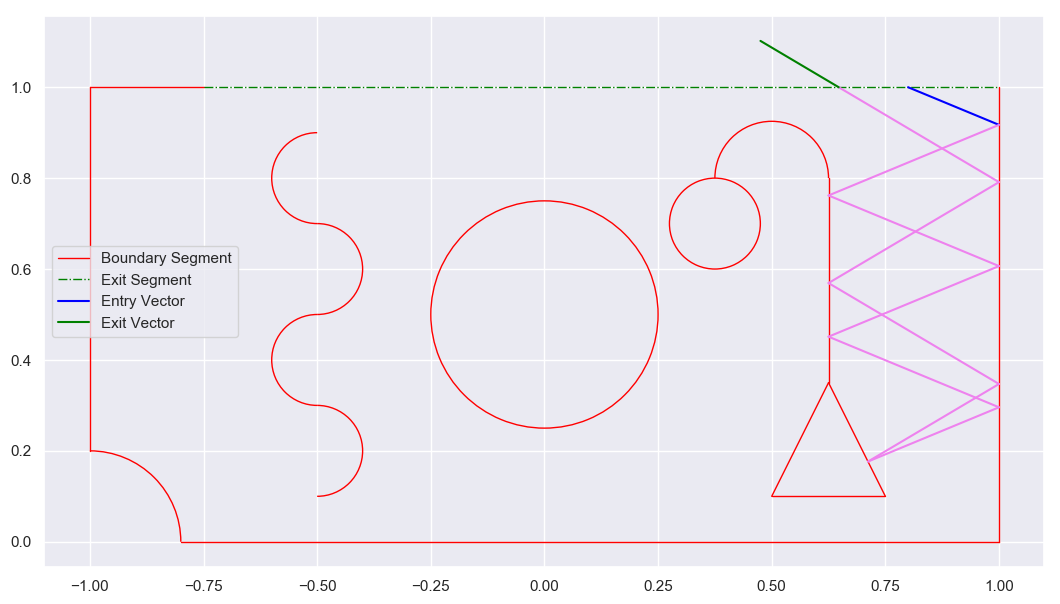

In [26]:
plot_billiard_cell(position_=0.80, init_angle_=np.pi/8, boundary_=example)

# Simulating the variance

These functions simulate a Markov chain of angles. From this chain the variance of the partial sums of the ubservable $f(\theta)=2\theta-\pi$ are calculated.

In [27]:
def single_particle(n_collisions, scatter):
    """
    Main function - 
    Generates a number of collisions (specified by N_COLLISIONS)
    for one particle in a circle according to the SCATTER function
    specifying the scattering in the billiard cells.  
    """
    results = []
    #---k odd is bottom plate, k even top plate---#
    for k in range(n_collisions-1):
        if k==0:
            scatter_theta = np.arccos(1-2*np.random.rand())
            
            #x, y, path_len, arc_len = init_collision(scatter_theta)
            #results.append([scatter_theta, x, y, path_len, arc_len])
            #x, y = init_collision(scatter_theta)
            results.append(scatter_theta)
            
        prev_theta = results[-1]
        #prev_x = results[-1][1]
        #prev_y = results[-1][2]
        
        scatter_theta = scatter(prev_theta)

        #x, y, path_len, arc_len = collision(prev_x, prev_y, scatter_theta)
        #x, y = collision(prev_x, prev_y, scatter_theta)
        
        #results.append([scatter_theta, x, y, path_len, arc_len])
        results.append(scatter_theta)

    return np.array(results)


def simulation(n_particles, n_collisions, scatter):
    L = [ single_particle(n_collisions, scatter) for _ in range(n_particles)]
    return np.stack(L, axis=0)

def varsample(M_samples, N_range, scatter, pass_data=False):
    """
    Main function -
    Simulates M particles at N collisions each and
    calculates the sample variance of partial
    sums of the position of the particles, as described above.
    """
    dat = simulation(M_samples, N_range, scatter)
        
    #---arrays for f---#
    zero_and_twos = np.insert(2*np.ones(N_range-1), 0, 1)
    #PIs = np.insert(np.pi*np.ones(N_range-1), 0, 0)
    
    #---apply f(X)=2X-PI to data---#
    f_on_thetas = dat*zero_and_twos #- PIs
    
    #---cummulative sum along arrays---#
    Sn = f_on_thetas.cumsum(axis=1)
    
    #---variance estimates along columns---#
    sigmas = Sn.var(axis=0)
    
    if pass_data:
        return sigmas, dat, Sn
    else:
        return sigmas

## Make the scatter function

In [28]:
p_Dist = ss.uniform()

scatter_f = lambda x: billiard_cell(
    init_angle_=x,
    angle_only_= True,
    position_= None,
    boundary_=example,
    entry_pos_dist_=p_Dist)

## The Markov chain

The function `scatter_f` specifies the billiard cell and how to generate the entry position. Here we are using the billiard cell in the example above and are choosing the position uniformly at random.

In [29]:
single_particle(n_collisions=11, scatter=scatter_f)

array([2.70038056, 0.38912484, 2.60342227, 0.6257631 , 1.22882733,
       1.66682873, 1.47476392, 0.95209765, 2.03651164, 0.74377541,
       1.23951543])

## The Variance

Several chains are simlated (specified by `M_samples`) each at a length specified by $N=$ `N_range`. The variance is calculated for each partial sum $S_k$, where $k=1, \ldots, N$. 

In [30]:
# test variance function
varsample(M_samples=7, N_range=21, scatter = scatter_f, pass_data=False)

array([ 0.66685872,  0.53937122,  0.84149129,  2.3208167 ,  5.68782733,
        6.48949943,  5.25708687, 14.19956099, 15.12384486, 20.62962996,
       16.45491144, 17.46768331, 20.13994674, 17.12061812, 21.34798675,
       18.81808101, 26.89857596, 27.75946255, 29.74947108, 35.3815535 ,
       44.72740278])

# Create Transition Matrix

For a given billiard cell the entry space is sampled uniformly and we make a finite rank approximation of the transition matrix. 

In [31]:
def finite_P(scatter_, theta_N, entry_N = 10**2, verbose=False, scale_=1):
    #---partition initial positions and entry angles---#
    #theta_bins = np.linspace(start=0, stop=np.pi, num=theta_N+1, endpoint=True)
    #theta_partition = theta_bins[1:-1]
    #---variables for other functions---#
    theta_bins = np.linspace(0, np.pi, num=theta_N+1, endpoint=True)
    theta_partition = (theta_bins[1:] + theta_bins[:-1]) / 2
    entry_partition = np.round(np.linspace(start=0, stop=1, num=entry_N+1, endpoint=False)[1:], 5)*scale_
    #print(f"first angle {theta_partition[0]}, first position {entry_partition[0]}")
        
    #---sampled arguments---#
    cell_args = np.array(
        np.meshgrid(
            theta_partition, entry_partition
        )).T.reshape(-1,2)
    
    #---exit angles---#
    entry_angles, exit_angles = [], []
    none_counter_ = 0
    for a_ in cell_args:
        try:
            t_ = scatter_(a_[0], a_[1])
            entry_angles.append(a_[0])
            exit_angles.append(t_)
        except TypeError:
            none_counter_ += 1
            #print(f"arguments {a_}")
            continue
    if verbose:
        print(f"number of passes: {none_counter_}")
    exit_angles = np.array(exit_angles)
    entry_angles = np.array(entry_angles)

    
    #---get i and j bin values for each entry/exit angles
    entry_thetas = np.searchsorted(
        theta_bins,
        entry_angles,
        side='right')
    exit_thetas = np.searchsorted(
        theta_bins,
        exit_angles,
        side='right')
    
    #---convert to dataframe---#
    bins_df = pd.DataFrame({
        "enter_bins": entry_thetas,
        "exit_bins": exit_thetas,
        "cnt":1
        })
    
    #---compute the counting matrix---#
    P_raw = bins_df\
        .groupby(["enter_bins", "exit_bins"])\
        .sum()\
        .reset_index()\
        .pivot(index='enter_bins', columns='exit_bins', values='cnt')\
        .fillna(0)
        
    #---return normalized matrix---#
    P_raw = np.array(P_raw)
    return P_raw/np.sum(P_raw, axis=1), theta_partition

def inner_prod(f, g):
    #---variables for other functions---#
    angle_bins = np.linspace(0, np.pi, num=len(g)+1, endpoint=True)
    bin_midpoints = (angle_bins[1:] + angle_bins[:-1]) / 2
    
    g_ = g*np.array([np.sin(z)/2 for z in bin_midpoints])
    return np.dot(f,g_)*(np.pi/len(f))

def var_from_P(P_, angle_bins_, flag=False):
    #P_ = LA.matrix_power(P_, 2)
    D = P_.shape[0]
    f_ = np.array([2*x for x in angle_bins_]) - np.pi
    IMP_ = np.identity(D) - P_
    
    g_, inf_ = SSLA.bicgstab(IMP_, f_, tol=10**(-2))
    
    v_est = inner_prod(f_,f_) + 2*inner_prod(np.matmul(P_, f_), g_)
    return v_est

def var_from_Pseries(P_, angle_bins_, sumN = 20):
    f_ = np.array([2*x for x in angle_bins_]) - np.pi
    
    Ppowers = np.array([LA.matrix_power(P_, i) for i in range(sumN)])
    Ppowers_on_f = np.array([np.matmul(M, f_) for M in Ppowers])
            
    g_ = np.sum(Ppowers_on_f, axis=0)
    v_est = inner_prod(f_,f_) + 2*inner_prod(np.matmul(P_, f_), g_)
    
    return v_est

In [32]:
bd = bumps_with_wall(radius_=0.75, wall_width_=0.3, wall_height_=0.2)
scatter_ = lambda x, y : billiard_cell(
    init_angle_=x,
    position_=y,
    angle_only_=True,
    boundary_=bd)

In [33]:
P, tp = finite_P(scatter_, theta_N = 33, entry_N = 10**2, verbose=False, scale_=1.50+0.3)

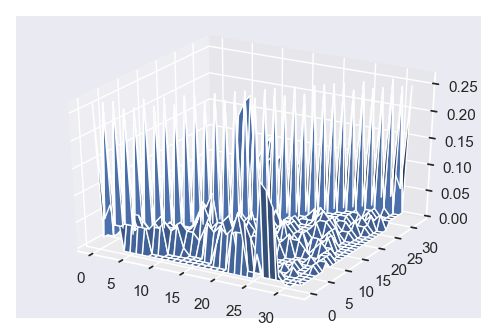

In [34]:
surface_plot(P)
plt.show()

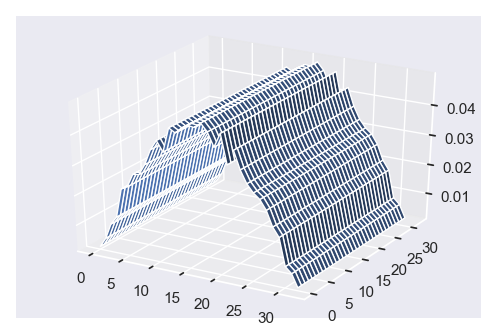

In [35]:
surface_plot(LA.matrix_power(P, 100))
plt.show()

In [36]:
def var_from_P(P_, angle_bins_, observable_f):
    #P_ = LA.matrix_power(P_, 2)
    D = P_.shape[0]
    f_ = np.array([observable_f(x) for x in angle_bins_])
    IMP_ = np.identity(D) - P_
    
    g_, inf_ = SSLA.bicgstab(IMP_, f_, tol=10**(-2))
    
    v_est = inner_prod(f_,f_) + 2*inner_prod(np.matmul(P_, f_), g_)
    return v_est

## Transiton Matrix: Bumps

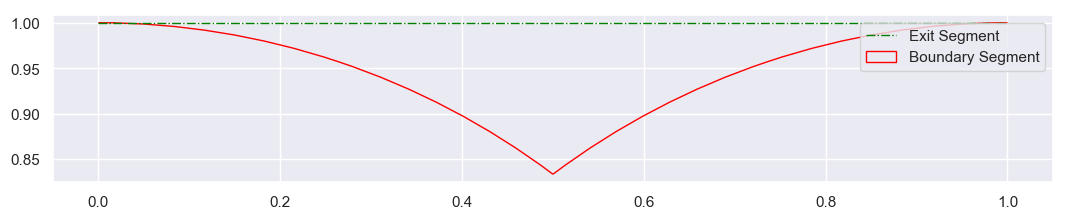

In [37]:
# use bumps for example
example2 = bumps_family(5/6)
plot_segments(example2)

In [38]:
# make scatter function for P estimates
scatter_for_P_est = lambda x, y : billiard_cell(
    init_angle_=x,
    position_=y,
    angle_only_=True,
    boundary_=example2)

P1, theta_partition = finite_P(scatter_=scatter_for_P_est, entry_N=10**3, theta_N=50)

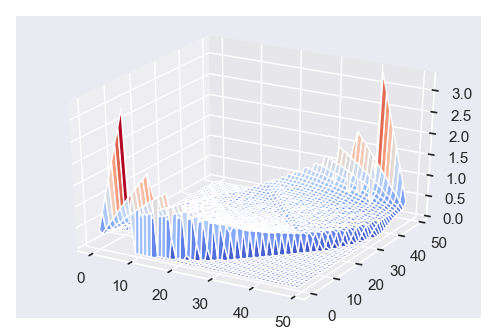

In [39]:
surface_plot(matrix=P1/(np.pi/P1.shape[0]), cmap=plt.cm.coolwarm)
plt.show()

## Transition Matrix: Bumps with wall

In [40]:
# use bumps for example
example2 = bumps_with_wall(radius_=5/6, wall_height_=1/16, wall_width_=1/8)
#plot_segments(example2)

In [41]:
# make scatter function for P estimates
scatter_for_P_est = lambda x, y : billiard_cell(
    init_angle_=x,
    position_=y,
    angle_only_=True,
    boundary_=example2)

P1, theta_partition = finite_P(scatter_=scatter_for_P_est, entry_N=10**2, theta_N=50)

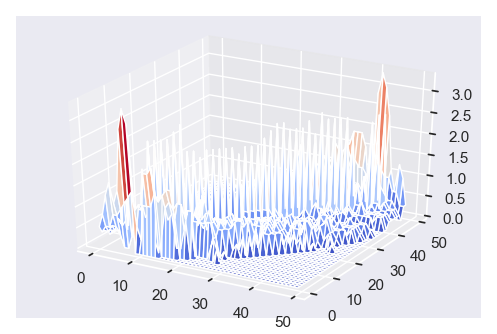

In [42]:
surface_plot(matrix=P1/(np.pi/P1.shape[0]), cmap=plt.cm.coolwarm)
plt.show()

## Transition Matrix: Triangles

In [43]:
example2 = triangle_family(y_=1-(1/np.pi))
#plot_segments(example2)

In [44]:
# make scatter function for P estimates
scatter_for_P_est = lambda x, y : billiard_cell(
    init_angle_=x,
    position_=y,
    angle_only_=True,
    boundary_=example2)

P1, theta_partition = finite_P(scatter_=scatter_for_P_est, entry_N=10**2, theta_N=50)

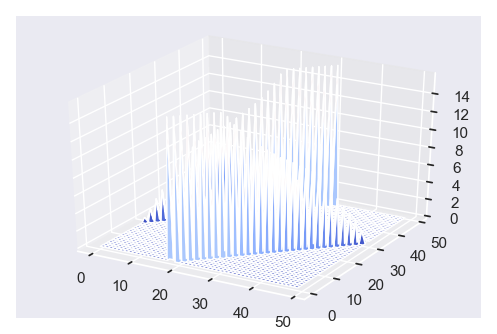

In [45]:
surface_plot(matrix=P1/(np.pi/P1.shape[0]),  cmap=plt.cm.coolwarm)
plt.show()

# Variance estimate from transition matrix

With a finite rank transition matrix we can now extimate the variance using 
    \begin{equation}
    \sigma^2_f = \langle f, f \rangle + 2 \langle Pf, g \rangle,
    \end{equation}
The function $g$ can be found by computing $(I-P)^{-1}f$ or by the series $\sum_{i=0}^K P^if$. These are done with the functions `var_from_P` and `var_from_Pseries`, respectively. 

In [46]:
f_ = lambda x: 2*x-np.pi
var_from_P(P_=P1, angle_bins_=theta_partition, observable_f=f_)

1.9067022941290706

In [47]:
# few terms
var_from_Pseries(P_=P1, angle_bins_=theta_partition, sumN=10)

1.5230320417038934

In [48]:
# 200 terms
var_from_Pseries(P_=P1, angle_bins_=theta_partition, sumN=200)

1.8955271835227552

# Galerkin Method Functions

Also once we have a finite rank approximation of the transition matrix we can find get an approximate solution to the Poisson equation via the Galerkin method - then using this $g$ we can approximate the variance as above. 

In [49]:
from scipy.special import lpmv as legendre_f #legendre functions

def eval_legendre(n_, theta_partition):
    return np.array([legendre_f(0, n_, np.cos(x)) for x in theta_partition])

def galerkin_var(P_, theta_partition_, galerkinN_):
    #---the observable---#
    f_ = 2*theta_partition_ - np.pi

    Y_ = np.array([
        inner_prod(f_, eval_legendre(i, theta_partition_)) for i in range(galerkinN_)
    ])
    
    #--list of P*Phi_j---#
    P_on_Legendr_ = [
        np.matmul(P_, eval_legendre(i, theta_partition_)) for i in range(galerkinN_)
    ]

    #--matrix of <P*Phi_j, Phi_i> for i,j---#
    P_inner_Legendr_ = np.array([
        np.array([inner_prod(m_, eval_legendre(i, theta_partition_))
                  for i in range(galerkinN_)])
                       for m_ in P_on_Legendr_
    ])
    
    C_  = np.diag([1/(2*j+1) for j in range(galerkinN_)]) - P_inner_Legendr_
    
    alphas_ = LA.solve(C_, Y_)
    
    g_ = np.sum(
    alphas_[:,None]*np.array([np.array(eval_legendre(i, theta_partition_)) for i in range(galerkinN_)]), 
    axis=0)
    
    var_ = inner_prod(f_,f_) + 2*inner_prod(np.matmul(P_, f_), g_)
    return var_, g_
    #return alphas_, np.array([np.array(eval_legendre(i, theta_partition_)) for i in range(galerkinN_)])

In [50]:
var_from_galerkin, g_sol = galerkin_var(P_=P1, theta_partition_=theta_partition, galerkinN_=16)
print(var_from_galerkin)

1.8978873758379957
